<a href="https://colab.research.google.com/github/fernandoGitHub/ML_Projects/blob/main/Yolo-Part-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autonomous Driving - Car Detection - Part 2

Many of the ideas in this notebook are described in the two YOLO papers: [Redmon et al., 2016](https://arxiv.org/abs/1506.02640) and [Redmon and Farhadi, 2016](https://arxiv.org/abs/1612.08242). 

In this hands-on we will:
- Load a pre-trained yolo (using Google Drive)
- Detect objects in a car detection dataset
- Implement non-max suppression to increase accuracy
- Implement intersection over union
- Handle bounding boxes, a type of image annotation popular in deep learning

# 1 - Packages & Setup

In [1]:
import argparse
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import PIL

import imghdr
import colorsys
import random
import shutil
from functools import reduce

import scipy.io
import scipy.misc

import tensorflow as tf
import tensorflow.keras.models as tfm
import tensorflow.keras.backend as tfK
from tensorflow.python.framework.ops import EagerTensor

%matplotlib inline

In [2]:
# Installing packages without !pip
import sys
import subprocess as sp
import pkg_resources

def install_package(package, reload = True):
  # Veryfing existing install prior to install
  if is_installed(package):
    print (f'Package: {package} is already installed. Skipping installation')
  else:
    print(f'Installing {package} ...')
    sp.check_call([sys.executable, '-m', 'pip', 'install', package])
    print(f'Package {package} has been successfully installed')

  if reload:
    reload_packages()

def is_installed (package):
  # Getting all the list of packages
  return (package in get_installed_packages())

def get_installed_packages():
  return sorted({pkg.key for pkg in pkg_resources.working_set})

def reload_packages():
  print ('Reloading Packages')
  import pkg_resources
  import importlib
  importlib.reload(pkg_resources)

In [3]:
install_package('wget')
import wget

install_package('ipdb')
import ipdb
%pdb on

Installing wget ...
Package wget has been successfully installed
Reloading Packages
Installing ipdb ...
Package ipdb has been successfully installed
Reloading Packages
Automatic pdb calling has been turned ON


In [4]:
# Copying data from Github to session
_MODEL_DATA_DIR = './model_data'
_MODEL_FILES = ['anchors.txt', 'coco_classes.txt', 'pascal_classes.txt', 'saved_model.pb', 'yolo_anchors.txt', 'Elvis.jpg']
_GITHUB_DIR_URL = 'https://github.com/fernandoGitHub/ML_Projects/raw/main/Yolo/data/'

# Remove default sample_data directory
if os.path.isdir('./sample_data'):
  shutil.rmtree('./sample_data')
  print('Removing default sample_data directory...')

if os.path.isdir(_MODEL_DATA_DIR):
  shutil.rmtree(_MODEL_DATA_DIR)
  print(f'Removing old {_MODEL_DATA_DIR} directory...')
os.makedirs(_MODEL_DATA_DIR)

# DOWNLOADING PRE-TRAINED YOLO DATA
os.makedirs(os.path.join(_MODEL_DATA_DIR, 'variables'))
! gdown 1Y2b8NsmmFsdQmgYGmWMQVgOylc7idgoy
! gdown 1Y8f-axZmqr73uYKi4fTA8hOPGospm1DR
os.replace('variables.index', './model_data/variables/variables.index')
os.replace('variables.data-00000-of-00001', './model_data/variables/variables.data-00000-of-00001')

for file in _MODEL_FILES:
  _FILE_PATH = os.path.join(_MODEL_DATA_DIR, file)
  if not os.path.isfile(_FILE_PATH):
    _URL_PATH = os.path.join(_GITHUB_DIR_URL, file)
    file_name = wget.download(_URL_PATH)
    print(f"Fetching from GitHub: {file} ...")
    os.replace(os.path.join('.', file), _FILE_PATH)

Removing default sample_data directory...
Downloading...
From: https://drive.google.com/uc?id=1Y2b8NsmmFsdQmgYGmWMQVgOylc7idgoy
To: /content/variables.data-00000-of-00001
100% 204M/204M [00:01<00:00, 131MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Y8f-axZmqr73uYKi4fTA8hOPGospm1DR
To: /content/variables.index
100% 7.29k/7.29k [00:00<00:00, 8.05MB/s]
Fetching from GitHub: anchors.txt ...
Fetching from GitHub: coco_classes.txt ...
Fetching from GitHub: pascal_classes.txt ...
Fetching from GitHub: saved_model.pb ...
Fetching from GitHub: yolo_anchors.txt ...
Fetching from GitHub: Elvis.jpg ...


In [5]:
# Copying images from Github to session
_IMAGES_DIR = './images'
_GITHUB_DIR_URL = 'https://github.com/fernandoGitHub/ML_Projects/raw/main/Yolo/images/'

if not os.path.isdir(_IMAGES_DIR):
  print(f'Creating {_IMAGES_DIR} directory...')
  os.makedirs(_IMAGES_DIR)

print('Retrieving 120 image files from GitHub')
for i in range(1, 121):
  file = str(i).zfill(4)+'.jpg'
  _FILE_PATH = os.path.join(_IMAGES_DIR, file)
  if not os.path.isfile(_FILE_PATH):
    _URL_PATH = os.path.join(_GITHUB_DIR_URL, file)
    file_name = wget.download(_URL_PATH)
    os.replace(os.path.join('.', file), _FILE_PATH)

Creating ./images directory...
Retrieving 120 image files from GitHub


In [6]:
# Copying Arial Fonts to Colab
_FONTS_DIR = '/usr/share/fonts/truetype/arial'
_FONT_FILE = 'arial.ttf'
_GITHUB_DIR_URL = 'https://github.com/fernandoGitHub/ML_Projects/raw/main/Yolo/data/'

if not os.path.isdir(_FONTS_DIR):
  os.makedirs(_FONTS_DIR)

if not os.path.isfile(os.path.join(_FONTS_DIR, _FONT_FILE)):
  file_name = wget.download(os.path.join(_GITHUB_DIR_URL, _FONT_FILE))
  print(f"Fetching from GitHub: {_FONT_FILE} ...")
  os.replace(os.path.join('.', _FONT_FILE), os.path.join(_FONTS_DIR, _FONT_FILE))


Fetching from GitHub: arial.ttf ...


In [7]:
# Enabling Multi-output on Notebook cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 2 - Utilities

In [8]:
BOLD_ON ='\033[1m'
BOLD_OFF='\033[0m'
def print_bold(text):
  print(BOLD_ON+text+BOLD_OFF)

In [9]:
def render_image(image, image_name='Unspecified', display_text=True, zoom=1.0, RGB=True):
  """
  render_image plots the image values as well as each one of its channels
  using pseudocolors

  Arguments:
    image - a (HxWx3) array
    image_name - str containing the name of the image (default: Unspecified)
    display_text (default: True)
    zoom - float (default: 1.0)
    RGB - Boolean for display RGB pictures (default = True)
  """

  # Check for dimensions and correct shape if needed
  if len(image.shape) == 4 and image.shape[0] == 1:
    image = np.squeeze(image, axis=0)
  
  min_value =  str(np.round(np.min(image), 3))
  max_value =  str(np.round(np.max(image), 3))
  mean_value = str(np.round(np.mean(image), 3))
  print_bold(f'Image name: {image_name} - Image shape: {image.shape} - (min, max, mean) = ({min_value}, {max_value}, {mean_value})\n')

  if RGB:
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16*zoom,9*zoom))
    ax[0].imshow(image)
    ax[0].set_title('RGB channels')
    ax[1].imshow(image[:, :, 0])
    ax[1].set_title('R channel')
    ax[2].imshow(image[:, :, 1])
    ax[2].set_title('G channel')
    ax[3].imshow(image[:, :, 2])
    ax[3].set_title('B channel')
  else:
    fig = plt.figure(figsize=(20*zoom,8*zoom))
    plt.imshow(image)
    plt.title('RGB channels')

  plt.show()
  print('\n')

In [10]:
help(render_image)

Help on function render_image in module __main__:

render_image(image, image_name='Unspecified', display_text=True, zoom=1.0, RGB=True)
    render_image plots the image values as well as each one of its channels
    using pseudocolors
    
    Arguments:
      image - a (HxWx3) array
      image_name - str containing the name of the image (default: Unspecified)
      display_text (default: True)
      zoom - float (default: 1.0)
      RGB - Boolean for display RGB pictures (default = True)



In [11]:
def preprocess_image(img_path, model_image_size, render=True):
  """
  preprocess_image(img_path, model_image_size)
  does something that I want to find out
  Returns:
    image - A PIL image object
    image_data - A ndarray of size (1, H x W x 3)
    render - Boolean for calling render_image (default: True)
  """

  image_type = imghdr.what(img_path)

  image = PIL.Image.open(img_path)
  resized_image = image.resize(tuple(reversed(model_image_size)), PIL.Image.BICUBIC)
  image_data = np.array(resized_image, dtype='float32')
  image_data /= 255.
 
  if render:
    render_image(image_data, image_name=str(img_path).split("/")[-1], display_text=True)

  image_data = np.expand_dims(image_data, axis=0)

  return resized_image, image_data, image_type

In [12]:
help(preprocess_image)

Help on function preprocess_image in module __main__:

preprocess_image(img_path, model_image_size, render=True)
    preprocess_image(img_path, model_image_size)
    does something that I want to find out
    Returns:
      image - A PIL image object
      image_data - A ndarray of size (1, H x W x 3)
      render - Boolean for calling render_image (default: True)



Image name: Elvis.jpg - Image shape: (1024, 1024, 3) - (min, max, mean) = (0.0, 0.984, 0.491)



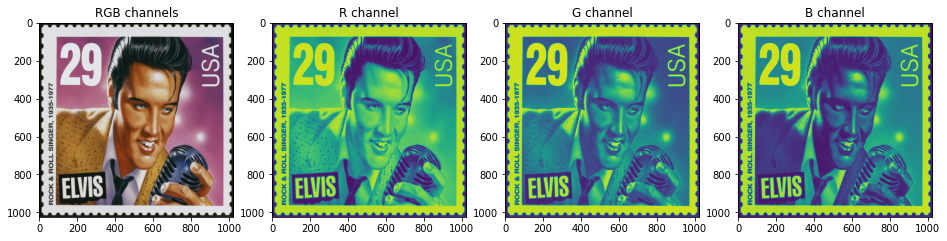



TYPES 	image: <class 'PIL.Image.Image'> 	 image_data: <class 'numpy.ndarray'> 	 image_type: <class 'str'>
image_type: jpeg
Image name: Channels Only - Image shape: (1024, 1024, 3) - (min, max, mean) = (0.0, 0.984, 0.491)



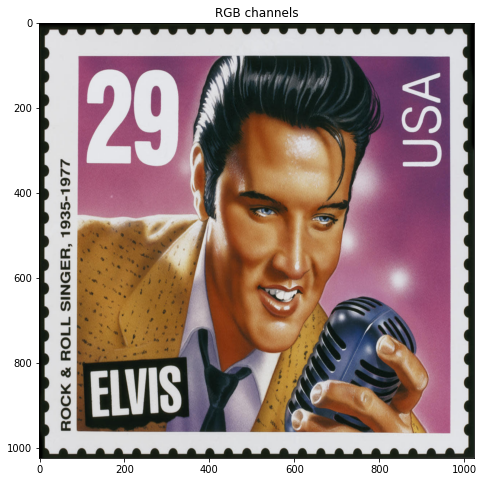



Image name: Channels Only - Image shape: (1024, 1024, 3) - (min, max, mean) = (0.0, 0.984, 0.491)



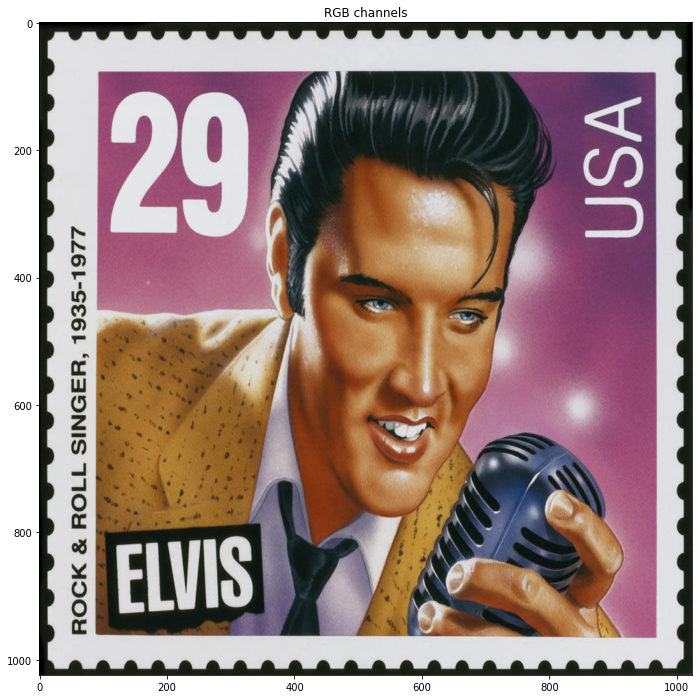

In [13]:
# UNITEST PREPROCESS_IMAGE
img_path = './model_data/Elvis.jpg'
model_image_size = (512*2, 512*2)

image, image_data, image_type = preprocess_image(img_path=img_path, model_image_size=model_image_size, render=True)

print(f'TYPES \timage: {type(image)} \t image_data: {type(image_data)} \t image_type: {type(image_type)}')
print(f'image_type: {image_type}')

render_image(image=image_data, image_name='Channels Only', zoom=1, RGB=False)

render_image(image=image_data, image_name='Channels Only', zoom=1.5, RGB=False)

In [14]:
def load_and_preprocess_images_from_directory(img_dir, file_type = 'jpg', image_size=(1024, 1024), render=True):
  
  # Cleaning checkpoints (if there)
  if os.path.isdir('./images/.ipynb_checkpoints'):
    shutil.rmtree('./images/.ipynb_checkpoints')

  files = os.listdir(img_dir)
  JPGs = [file for file in files if (file.endswith(file_type.upper()) or file.endswith(file_type.lower()))]

  images_NP = []
  for file in files:
    img_path = os.path.join(img_dir, file)
    image_PIL, image_np, image_type = preprocess_image(img_path, model_image_size=image_size, render=render)
    images_NP.append(np.squeeze(image_np, axis=0))

  return np.array(images_NP)

In [15]:
# UNITEST FOR LOAD_AND_PREPROCESS_IMAGES_FROM_DIRECTORY
images_NP = load_and_preprocess_images_from_directory(img_dir = './images', file_type='jpg', image_size=(608, 608), render=False)

In [16]:
# Reading classes and anchors from file
def read_classes(classes_path):
  """
  Reads a list of classes from a file

  Attributes:
  classes_path - string including the path to the file

  Returns:
  A list of strings (without spaces) including the names of the classes
  """

  with open(classes_path) as f:
    class_names = f.readlines()
  
  class_names = [c.strip() for c in class_names]  
  return class_names
  

def read_anchors(anchors_path):
  """
  Reads a list of anchors from a file
  Anchors sizes should be defined from 0 to 1

  Attributes:
  anchors_path - string including the path to the file

  Returns:
  A 2 columns ndarray with the size of the boxes
  """
  
  with open(anchors_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    
  anchors = np.array(anchors).reshape(-1, 2)
  return anchors

In [17]:
help(read_classes)

help(read_anchors)

Help on function read_classes in module __main__:

read_classes(classes_path)
    Reads a list of classes from a file
    
    Attributes:
    classes_path - string including the path to the file
    
    Returns:
    A list of strings (without spaces) including the names of the classes

Help on function read_anchors in module __main__:

read_anchors(anchors_path)
    Reads a list of anchors from a file
    Anchors sizes should be defined from 0 to 1
    
    Attributes:
    anchors_path - string including the path to the file
    
    Returns:
    A 2 columns ndarray with the size of the boxes



In [18]:
# UNITEST FOR LOAD DATA
class_names = read_classes(classes_path='./model_data/pascal_classes.txt')
print(f'Lenght: {len(class_names)} \t Type: {type(class_names)} \t')
print(f'Element[0]: {class_names[0]} \t Type: {type(class_names[0])}')
print('\n')

anchors = read_anchors(anchors_path='./model_data/anchors.txt')
print(f'Shape: {anchors.shape} \t Type: {type(anchors)} \t')
print(f'Elements[0,:]: {anchors[0,:]} \t Type: {type(anchors[0][0])}')

Lenght: 20 	 Type: <class 'list'> 	
Element[0]: aeroplane 	 Type: <class 'str'>


Shape: (5, 2) 	 Type: <class 'numpy.ndarray'> 	
Elements[0,:]: [0.57273  0.677385] 	 Type: <class 'numpy.float64'>


In [19]:
# Boxes related functions
def scale_boxes(boxes, image_shape):
  """ Scales the predicted boxes in order to be drawable on the image"""
  height = float(image_shape[0])
  width = float(image_shape[1])
  image_dims = tfK.stack([height, width, height, width])
  image_dims = tfK.reshape(image_dims, [1, 4])
  boxes = boxes * image_dims
  return boxes

In [20]:
# UNITEST FOR SCALE_BOXES


In [21]:
def get_colors_for_classes(num_classes):
  """
  Returns a list of random colors for number of classes given.
  The function has memory, so colors will only recalculate when 
  the number of classes changes.

  Attributes:
  - num_classes (int)

  Returns:
    - A list of 3 colors tuples (0-255, 0-255, 0-255)
  """
  
  # Use previously generated colors if num_classes is the same.
  if (hasattr(get_colors_for_classes, "colors") and len(get_colors_for_classes.colors) == num_classes):
    return get_colors_for_classes.colors

  hsv_tuples = [(x / num_classes, 1., 1.) for x in range(num_classes)]
  colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
  colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

  # Fixed seed for consistent colors across runs.
  random.seed(10101)

  # Shuffle colors to decorrelate adjacent classes.
  random.shuffle(colors)

  # Reset seed to default.
  random.seed(None)

  # Save colors for future calls.
  get_colors_for_classes.colors = colors  

  return colors

In [22]:
# UNITEST FOR GET_COLORS_FOR_CLASSES
colors = get_colors_for_classes(5)
print(colors)

# Verify it returns the same colors is number of classes hasn't changed
assert colors == get_colors_for_classes(5), 'The function should keep the same colors'

# Calculating new colors
colors = get_colors_for_classes(8)
print(colors)

[(255, 0, 0), (204, 0, 255), (0, 102, 255), (0, 255, 102), (203, 255, 0)]
[(127, 0, 255), (255, 0, 0), (255, 191, 0), (255, 0, 191), (0, 63, 255), (127, 255, 0), (0, 255, 255), (0, 255, 63)]


In [23]:
from PIL import ImageFont, ImageDraw

def draw_boxes_on_image(image, boxes, box_classes, class_names, scores=None):
  """
  Draw bounding boxes with class name and optional box score on image.

  Arguments:
    image: A PIL Image
    boxes: An `array` of shape (num_boxes, 4) containing box corners as
        (y_min, x_min, y_max, x_max).
    box_classes: A list of indices into `class_names`.
    class_names: A list of string class names.
    scores: A list of scores for each box.

  Returns:
    - A PIL image copy of the image modified with given bounding boxes.
      A nparray copy of the image modified with given bounding boxes.
  """

  # Calculating Font Size
  min_font_size = 30
  width, height = image.size
  fontsize = int(min(min_font_size, min(width, height)/10))
  font = ImageFont.truetype('arial', fontsize)
   
  # Calculating box thickness as function of size in pixels
  thickness = (image.size[0] + image.size[1]) // 300

  # Getting array of colors
  colors = get_colors_for_classes(len(class_names))

  for i, c in list(enumerate(box_classes)):
    box_class = class_names[c]
    box = boxes[i]
    
    if isinstance(scores.numpy(), np.ndarray):
      score = scores.numpy()[i]
      label = '{} {:.2f}'.format(box_class, score)
    else:
      label = '{}'.format(box_class)

    draw = ImageDraw.Draw(image)
    label_size = draw.textsize(label, font)

    top, left, bottom, right = box
    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
    right = min(image.size[0], np.floor(right + 0.5).astype('int32'))

    if top - label_size[1] >= 0:
      text_origin = np.array([left, top - label_size[1]])
    else:
      text_origin = np.array([left, top + 1])

    for j in range(thickness):
      draw.rectangle([left + j, top + j, right - j, bottom - j], outline=colors[c])
    draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
 
    draw.text(tuple(text_origin), label, fill='black', font=font)
    del draw

  image_data = np.array(image)

  return image, image_data

In [24]:
help(draw_boxes_on_image)
# Previously called draw_boxes

Help on function draw_boxes_on_image in module __main__:

draw_boxes_on_image(image, boxes, box_classes, class_names, scores=None)
    Draw bounding boxes with class name and optional box score on image.
    
    Arguments:
      image: A PIL Image
      boxes: An `array` of shape (num_boxes, 4) containing box corners as
          (y_min, x_min, y_max, x_max).
      box_classes: A list of indices into `class_names`.
      class_names: A list of string class names.
      scores: A list of scores for each box.
    
    Returns:
      - A PIL image copy of the image modified with given bounding boxes.
        A nparray copy of the image modified with given bounding boxes.



Image name: Altered image - Image shape: (1024, 1024, 3) - (min, max, mean) = (0, 255, 125.446)



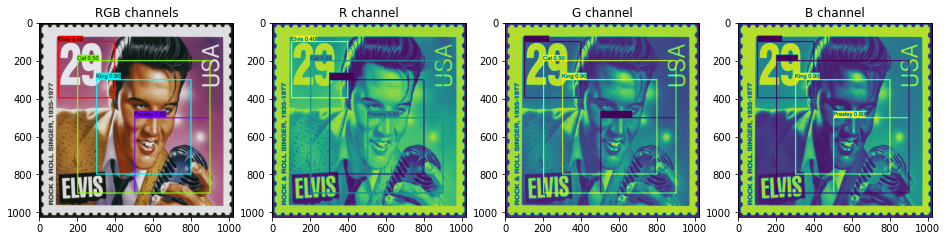

In [26]:
# UNITEST FOR DRAW BOXES
boxes = [[100, 100, 400, 400], [500, 500, 900, 900], [300, 300, 800, 800], [200, 200, 900, 900]]
box_classes = [0, 1, 2, 3]
class_names = ['Elvis', 'Presley', 'King', 'Cat']
scores = tf.constant([0.4, 0.8, 0.9, 0.5])

image, image_data, image_type = preprocess_image(img_path=img_path, model_image_size=model_image_size, render=False)
new_image, new_image_data = draw_boxes_on_image(image=image, boxes=boxes, box_classes=box_classes, class_names=class_names, scores=scores)
render_image(image=new_image_data, image_name='Altered image')

In [27]:
def convert_boxes_to_corners_coordinates(box_xy, box_wh):
    """
    Converts YOLO box predictions to bounding box corners.
    Attributes:
      - box_xy - A tensorflow vector of [None, grid_x, grid_y, no_classes, 2] indicating the top-leftmost coordinate of the box
      - box_wh - A tensorflow vector of [None, grid_x, grid_y, no_classes, 2] indicating the weight and height in pixels of the box
    
    Returns:
      - A tensorflow.python.framework.ops.EagerTensor containing the coordinates of the corners
      - A np.ndarray containing the coordinates of the corners
    """

    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    eager_tensor_version = tfK.concatenate([box_mins[..., 1:2], box_mins[..., 0:1], box_maxes[..., 1:2], box_maxes[..., 0:1]])
    np_ndarray_version = eager_tensor_version.numpy()

    return eager_tensor_version, np_ndarray_version

In [28]:
help(convert_boxes_to_corners_coordinates)
# Previously called yolo_boxes_to_corners !!

Help on function convert_boxes_to_corners_coordinates in module __main__:

convert_boxes_to_corners_coordinates(box_xy, box_wh)
    Converts YOLO box predictions to bounding box corners.
    Attributes:
      - box_xy - A tensorflow vector of [None, grid_x, grid_y, no_classes, 2] indicating the top-leftmost coordinate of the box
      - box_wh - A tensorflow vector of [None, grid_x, grid_y, no_classes, 2] indicating the weight and height in pixels of the box
    
    Returns:
      - A tensorflow.python.framework.ops.EagerTensor containing the coordinates of the corners
      - A np.ndarray containing the coordinates of the corners



In [29]:
# UNITEST for CONVERT_BOXES_TO_CORNERS_COORDINATES
grid_x = 19
grid_y = 19
n_classes = 5
box_xy = tf.random.normal([grid_x, grid_y, n_classes, 2], mean=1, stddev=4, seed = 1)
box_wh = tf.random.normal([grid_x, grid_y, n_classes, 2], mean=1, stddev=4, seed = 1)
corners_eager, corners_ndarray = convert_boxes_to_corners_coordinates(box_xy=box_xy, box_wh=box_wh)

print(f'Eager Version - Type: {type(corners_eager)} \t Shape: {corners_eager.shape}')
print(f'Np Version    - Type: {type(corners_ndarray)} \t\t\t\t\t Shape: {corners_ndarray.shape}')

Eager Version - Type: <class 'tensorflow.python.framework.ops.EagerTensor'> 	 Shape: (19, 19, 5, 4)
Np Version    - Type: <class 'numpy.ndarray'> 					 Shape: (19, 19, 5, 4)


# 3 - Yolo Network Implementation

In [30]:
def yolo_head(feats, anchors, num_classes):
  """Convert final layer features to bounding box parameters.

  Parameters
  ----------
  feats : tensor
      Final convolutional layer features.
  anchors : array-like
      Anchor box widths and heights.
  num_classes : int
      Number of target classes.

  Returns
  -------
  box_xy : tensor
      x, y box predictions adjusted by spatial location in conv layer.
  box_wh : tensor
      w, h box predictions adjusted by anchors and conv spatial resolution.
  box_conf : tensor
      Probability estimate for whether each box contains any object.
  box_class_pred : tensor
      Probability distribution estimate for each box over class labels.
  """
  num_anchors = len(anchors)
  # Reshape to batch, height, width, num_anchors, box_params.
  anchors_tensor = tfK.reshape(tfK.variable(anchors), [1, 1, 1, num_anchors, 2])

  # Dynamic implementation of conv dims for fully convolutional model.
  conv_dims = tfK.shape(feats)[1:3]  # assuming channels last

  # In YOLO the height index is the inner most iteration.
  conv_height_index = tfK.arange(0, stop=conv_dims[0])
  conv_width_index = tfK.arange(0, stop=conv_dims[1])
  conv_height_index = tfK.tile(conv_height_index, [conv_dims[1]])

  # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
  # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
  conv_width_index = tfK.tile(
      tfK.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
  conv_width_index = tfK.flatten(tfK.transpose(conv_width_index))
  conv_index = tfK.transpose(tfK.stack([conv_height_index, conv_width_index]))
  conv_index = tfK.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
  conv_index = tfK.cast(conv_index, tfK.dtype(feats))

  feats = tfK.reshape(
      feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
  conv_dims = tfK.cast(tfK.reshape(conv_dims, [1, 1, 1, 1, 2]), tfK.dtype(feats))

  box_xy = tfK.sigmoid(feats[..., :2])
  box_wh = tfK.exp(feats[..., 2:4])
  box_confidence = tfK.sigmoid(feats[..., 4:5])
  box_class_probs = tfK.softmax(feats[..., 5:])

  # Adjust preditions to each spatial grid point and anchor size.
  # Note: YOLO iterates over height index before width index.
  box_xy = (box_xy + conv_index) / conv_dims
  box_wh = box_wh * anchors_tensor / conv_dims

  return box_xy, box_wh, box_confidence, box_class_probs

# 4 - Autonomous Driving using Yolo
You are working on a self-driving car. Go you! As a critical component of this project, you'd like to first build a car detection system. To collect data, you've mounted a camera to the hood (meaning the front) of the car, which takes pictures of the road ahead every few seconds as you drive around. 

You've gathered all these images into a folder and labelled them by drawing bounding boxes around every car you found. Here's an example of what your bounding boxes look like:

<a name='3-2'></a>
##4.1 - Loading a Pre-trained Model

Training a YOLO model takes a very long time and requires a fairly large dataset of labelled bounding boxes for a large range of target classes. You are going to load an existing pre-trained Keras YOLO model stored in "yolo.h5". These weights come from the official YOLO website, and were converted using a function written by Allan Zelener. References are at the end of this notebook. Technically, these are the parameters from the "YOLOv2" model, but are simply referred to as "YOLO" in this notebook.

In [31]:
yolo_model = tfm.load_model("model_data/", compile=False)

/usr/local/lib/python3.7/dist-packages/keras/layers/core/lambda_layer.py:305: UserWarning: yad2k.models.keras_yolo is not loaded, but a Lambda layer uses it. It may cause errors.
  'function_type')
/usr/local/lib/python3.7/dist-packages/keras/layers/core/lambda_layer.py:310: UserWarning: yad2k.models.keras_yolo is not loaded, but a Lambda layer uses it. It may cause errors.
  'output_shape_type')


In [32]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                      

<figure>
  <img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Yolo/notebook_images/box_label.png" width="800px" height="450px">
  <figcaption align="center">Figure - Example of box definition</figcaption>
</figures>

Pictures taken from a car-mounted camera while driving around Silicon Valley. <br> Dataset provided by <a href="https://www.drive.ai/">drive.ai</a>.
</center></caption>

If there are 80 classes you want the object detector to recognize, you can represent the class label $c$ either as an integer from 1 to 80, or as an 80-dimensional vector (with 80 numbers) one component of which is 1, and the rest of which are 0, according to what is more convenient for a particular step.  

"You Only Look Once" (YOLO) is a popular algorithm because it achieves high accuracy while also being able to run in real time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

Inputs and outputs
- The **input** is a batch of images, and each image has the shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

Anchor Boxes
* Anchor boxes are chosen by exploring the training data to choose reasonable height/width ratios that represent the different classes.  For this assignment, 5 anchor boxes were chosen for you (to cover the 80 classes), and stored in the file './model_data/yolo_anchors.txt'
* The dimension of the encoding tensor of the second to last dimension based on the anchor boxes is $(m, n_H,n_W,anchors,classes)$.
* The YOLO architecture is: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).  


Encoding
Let's look in greater detail at what this encoding represents. 

<figure>
  <img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Yolo/notebook_images/architecture.png" width="800px" height="450px">
  <figcaption align="center">Figure - Solution Architecture</figcaption>
</figures>

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

Since you're using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.

For simplicity, you'll flatten the last two dimensions of the shape (19, 19, 5, 85) encoding, so the output of the Deep CNN is (19, 19, 425).

<figure>
  <img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Yolo/notebook_images/flatten.png" width="900px" height="450px">
  <figcaption align="center">Figure - Flattening Results</figcaption>
</figures>

**Class score**

Now, for each box (of each cell) you'll compute the following element-wise product and extract a probability that the box contains a certain class.  
The class score is $score_{c,i} = p_{c} \times c_{i}$: the probability that there is an object $p_{c}$ times the probability that the object is a certain class $c_{i}$.

<figure>
  <img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Yolo/notebook_images/probability_extraction.png" width="900px" height="350px">
  <figcaption align="center">Figure - Probability Calculation</figcaption>
</figures>

**Visualizing classes**

Here's one way to visualize what YOLO is predicting on an image:

- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across the 80 classes, one maximum for each of the 5 anchor boxes).
- Color that grid cell according to what object that grid cell considers the most likely.

Doing this results in this picture: 

<figure>
  <img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Yolo/notebook_images/proba_map.png" width="600px" height="350px">
  <figcaption align="center">Figure - Results Display on Grid</figcaption>
</figures>

Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:

<figure>
  <img src="https://github.com/fernandoGitHub/ML_Projects/raw/main/Yolo/notebook_images/anchor_map.png" width="500px" height="350px">
  <figcaption align="center">Figure - Results Display on Grid</figcaption>
</figures>

## 4.2 - Defining Classes, Anchors and Image Shape

We're trying to detect 80 classes, and are using 5 anchor boxes. The information on the 80 classes and 5 boxes is gathered in two files: "coco_classes.txt" and "yolo_anchors.txt". You'll read class names and anchors from text files. The car detection dataset has 720x1280 images, which are pre-processed into 608x608 images.

In [33]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608) # Same as yolo_model input layer size

## 4.3 - Non-Max Suppression

For **non-max suppression** we'll carry out these steps: 
- Get rid of boxes with a low score. Meaning, the box is not very confident about detecting a class, either due to the low probability of any object, or low probability of this particular class.
- Select only one box when several boxes overlap with each other and detect the same object.

In [34]:
def yolo_filter_boxes_by_threshold(boxes, box_confidence, box_class_probs, threshold = .6):
    """
    Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    box_scores = np.multiply(box_confidence, box_class_probs)

    box_classes = tf.math.argmax(box_scores, axis=-1, output_type=tf.dtypes.int64)

    box_class_scores = tf.math.reduce_max(box_scores, axis=-1, keepdims=False)

    filtering_mask = box_class_scores > threshold

    scores = box_class_scores[filtering_mask]
    boxes = boxes[filtering_mask]
    classes = box_classes[filtering_mask]

    return scores, boxes, classes

Even after filtering by thresholding over the class scores, you still end up with a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS). 

![Non-max Suppression](https://github.com/fernandoGitHub/ML_Projects/raw/main/Yolo/notebook_images/non-max-suppression.png)
<figcaption align=center>Non-Max Suppression Example</figcaption>


In this example, the model has predicted 3 cars, but it's actually 3 predictions of the same car. Running non-max suppression (NMS) will select only the most accurate (highest probability) of the 3 boxes. <br> </center></caption>


In [35]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None, ), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
  
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold=0.5)
    
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)

    return scores, boxes, classes

##4.4 - Evaluation
`yolo_encode_results()` takes the output of the YOLO encoding and filters the boxes using score threshold and NMS.  

YOLO's network was trained to run on 608x608 images. If you are testing this data on a different size image -- for example, the car detection dataset had 720x1280 images -- this step rescales the boxes so that they can be plotted on top of the original 720x1280 image.  

In [36]:
def yolo_encode_results(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs 
    boxes, _ = convert_boxes_to_corners_coordinates(box_xy, box_wh)
    
    # Filtering results
    scores, boxes, classes = yolo_filter_boxes_by_threshold(boxes, box_confidence, box_class_probs, threshold = score_threshold)
    
    # Scale boxes back to original image shape
    boxes = scale_boxes(boxes, image_shape)
    
    # Apply non max supression
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = max_boxes, iou_threshold = iou_threshold)
    
    return scores, boxes, classes

##4.5 - Predict

Finally, the predict method receives an image file, runs the prediction and detection algorithms and returns the results including image data for visualizaton

In [37]:
def predict(image_file):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data,_ = preprocess_image(image_file, model_image_size = (608, 608), render=False)
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_encode_results(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    # Print predictions info
    print_bold('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))

    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    image, image_data = draw_boxes_on_image(image=image, boxes=out_boxes, box_classes=out_classes, class_names=class_names, scores=out_scores)

    return out_scores, out_boxes, out_classes, image, image_data

# 5 - Test YOLO Pre-trained Model on Images
 

Found 9 boxes for images/./images/0005.jpg
Image name: Classified image - Image shape: (608, 608, 3) - (min, max, mean) = (0, 255, 85.847)



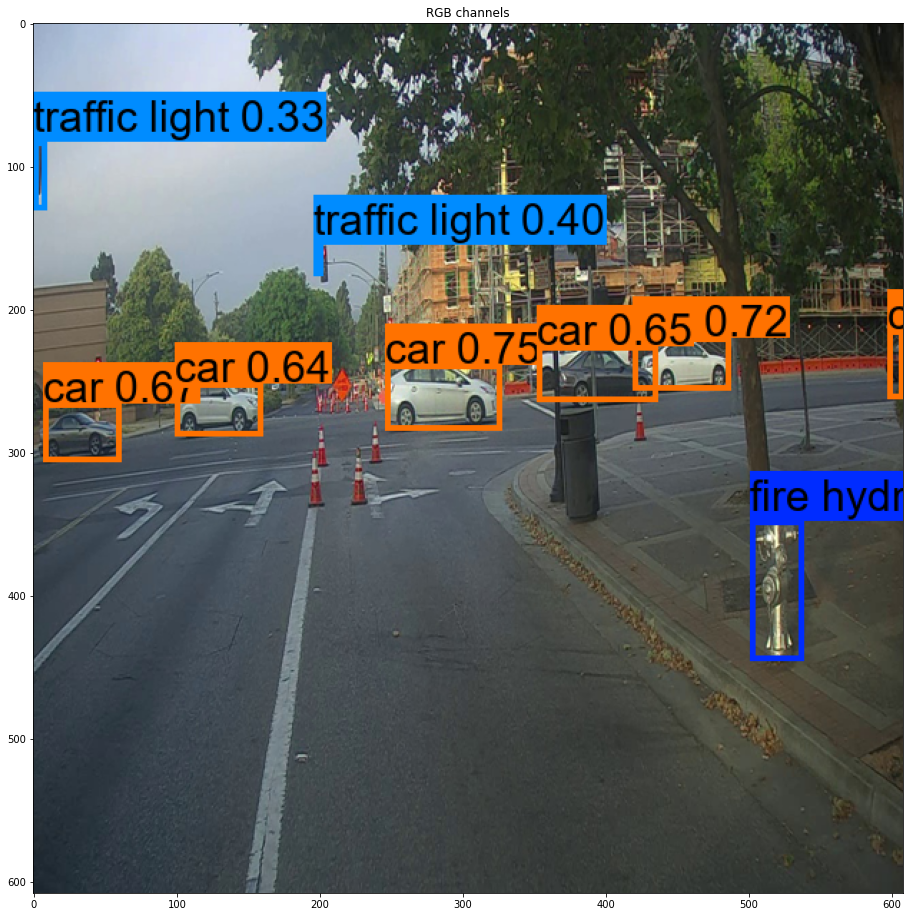

In [38]:
out_scores, out_boxes, out_classes, image, image_data = predict("./images/0005.jpg")

# Save the predicted bounding box on the image
# image.save("./out/005.jpg", quality=100)

render_image(image=image_data, image_name='Classified image', zoom=2.0, RGB=False)

And... as expected... we cannot finish without some Pandas stuff :-)
Let's create a big dataframe out of all the objects we found in the 120 pictures dataset

In [39]:
import pandas as pd

def return_predictions_as_df(images_dir, class_names, step, render=True):
  image_names = []
  objects = []
  probabilities = []
  boxes = []

  for i in range(1, 121, step):
    file = os.path.join(images_dir, str(i).zfill(4)+".jpg")
    out_scores, out_boxes, out_classes, image, image_data = predict(file)
    
    for j in range(len(out_scores)):
      image_names.append(file)
      objects.append(class_names[out_classes[j]])
      probabilities.append(np.round(out_scores[j].numpy(),2))
      boxes.append(out_boxes[j].numpy().astype(int))

    if render:
      render_image(image=image_data, RGB=False)

  res_df = pd.DataFrame(data=[image_names, objects, probabilities, boxes])
  res_df = res_df.transpose()
  res_df.columns = (['image name', 'object', 'Probability', 'Bounding Box'])

  return res_df

Found 4 boxes for images/./images/0001.jpg
Image name: Unspecified - Image shape: (608, 608, 3) - (min, max, mean) = (0, 255, 76.882)



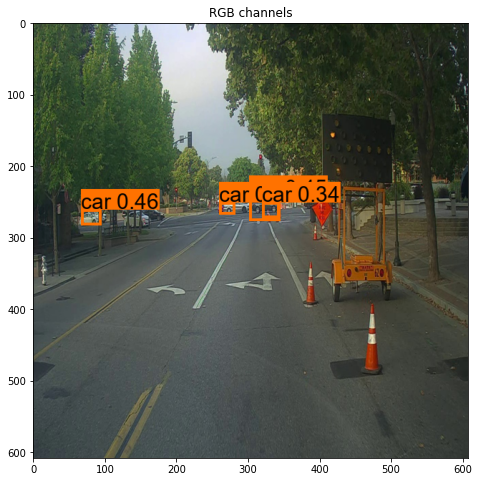



Found 3 boxes for images/./images/0011.jpg
Image name: Unspecified - Image shape: (608, 608, 3) - (min, max, mean) = (0, 255, 99.304)



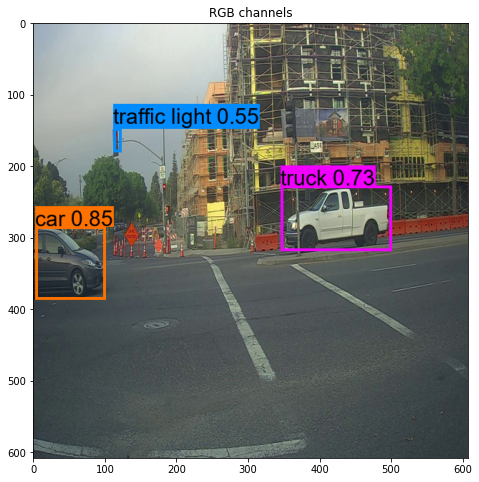



Found 2 boxes for images/./images/0021.jpg
Image name: Unspecified - Image shape: (608, 608, 3) - (min, max, mean) = (0, 255, 82.505)



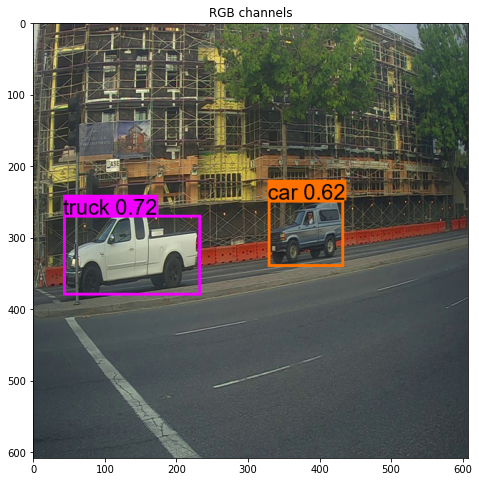



Found 8 boxes for images/./images/0031.jpg
Image name: Unspecified - Image shape: (608, 608, 3) - (min, max, mean) = (0, 255, 102.601)



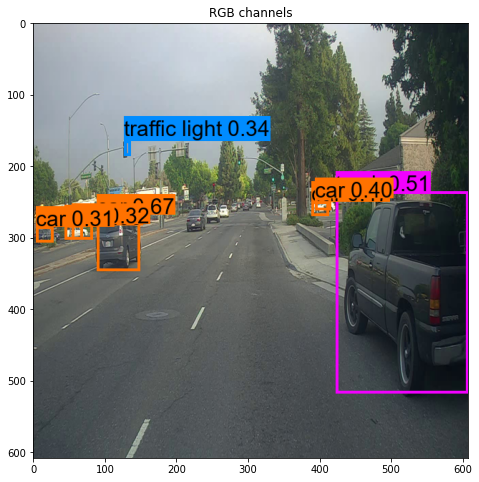



Found 2 boxes for images/./images/0041.jpg
Image name: Unspecified - Image shape: (608, 608, 3) - (min, max, mean) = (0, 255, 92.329)



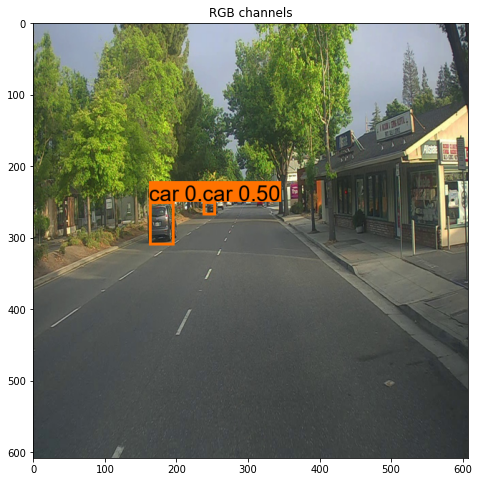



Found 7 boxes for images/./images/0051.jpg
Image name: Unspecified - Image shape: (608, 608, 3) - (min, max, mean) = (0, 255, 99.622)



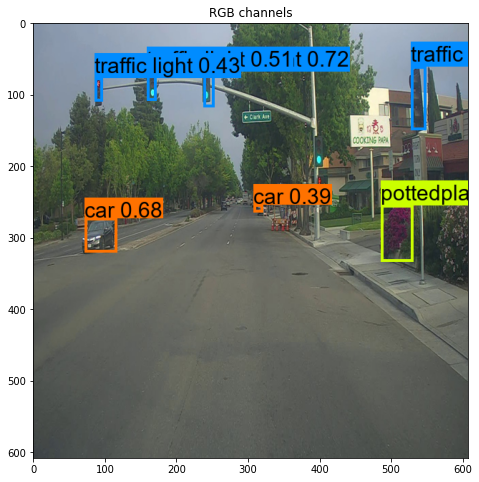



Found 0 boxes for images/./images/0061.jpg
Image name: Unspecified - Image shape: (608, 608, 3) - (min, max, mean) = (2, 255, 86.359)



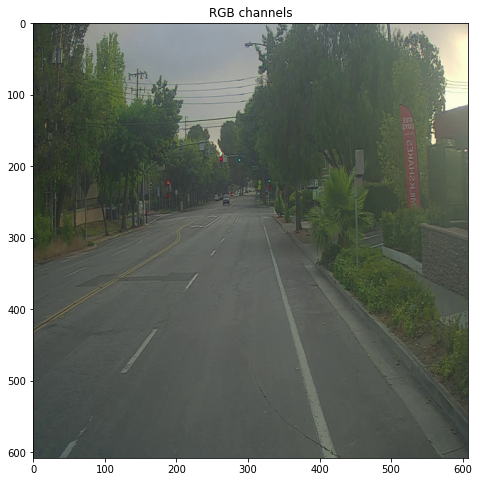



Found 6 boxes for images/./images/0071.jpg
Image name: Unspecified - Image shape: (608, 608, 3) - (min, max, mean) = (0, 255, 83.474)



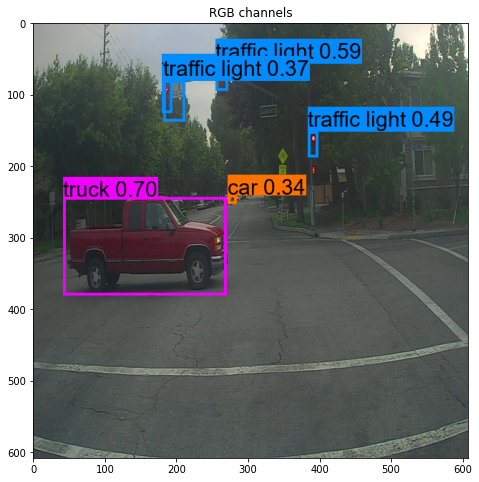



Found 10 boxes for images/./images/0081.jpg
Image name: Unspecified - Image shape: (608, 608, 3) - (min, max, mean) = (0, 255, 87.137)



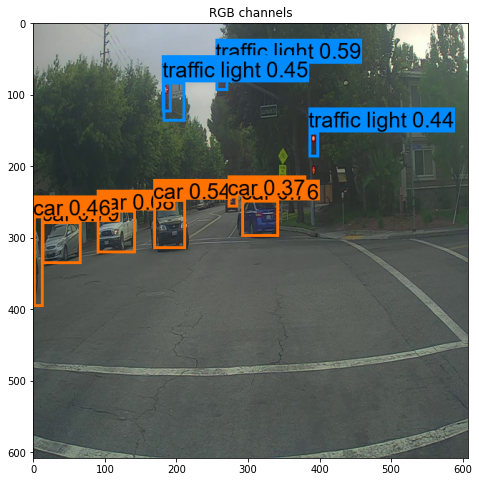



Found 4 boxes for images/./images/0091.jpg
Image name: Unspecified - Image shape: (608, 608, 3) - (min, max, mean) = (0, 255, 75.905)



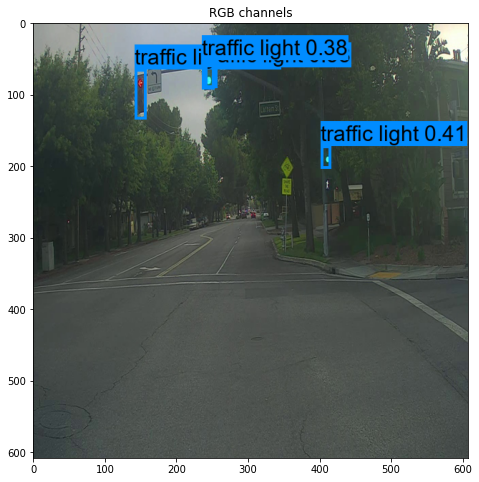



Found 1 boxes for images/./images/0101.jpg
Image name: Unspecified - Image shape: (608, 608, 3) - (min, max, mean) = (0, 255, 79.138)



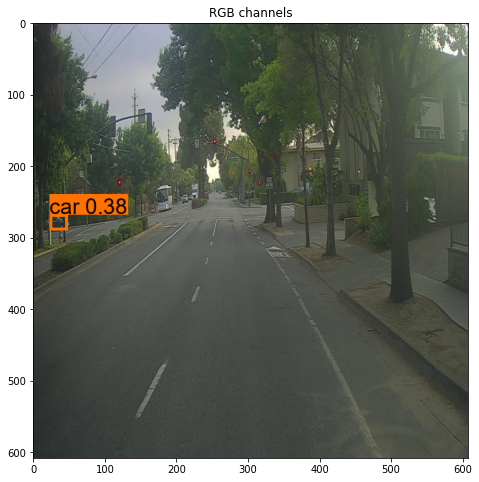



Found 4 boxes for images/./images/0111.jpg
Image name: Unspecified - Image shape: (608, 608, 3) - (min, max, mean) = (0, 255, 85.585)



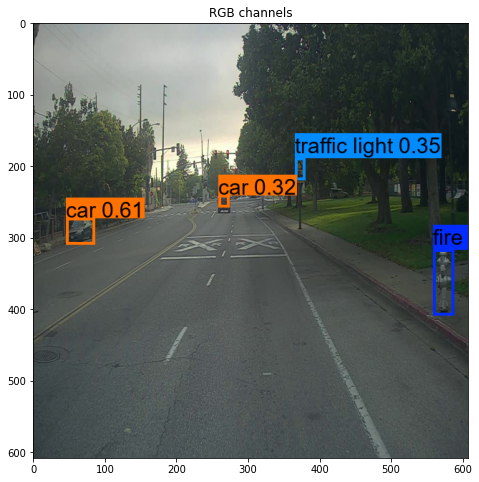

In [40]:
prediction_df = return_predictions_as_df(images_dir=_IMAGES_DIR, class_names=class_names, step = 10, render=True)

In [41]:
prediction_df

image name         object Probability          Bounding Box
0   ./images/0001.jpg            car        0.46    [260, 66, 281, 95]
1   ./images/0001.jpg            car        0.45  [240, 302, 275, 344]
2   ./images/0001.jpg            car        0.35  [249, 260, 267, 281]
3   ./images/0001.jpg            car        0.34  [249, 320, 272, 343]
4   ./images/0011.jpg            car        0.85    [283, 2, 385, 100]
5   ./images/0011.jpg          truck        0.73  [226, 345, 317, 500]
6   ./images/0011.jpg  traffic light        0.55  [147, 111, 179, 122]
7   ./images/0021.jpg          truck        0.72   [267, 41, 380, 234]
8   ./images/0021.jpg            car        0.62  [246, 328, 340, 434]
9   ./images/0031.jpg            car        0.67   [267, 88, 345, 148]
10  ./images/0031.jpg          truck        0.51  [234, 423, 516, 618]
11  ./images/0031.jpg            car        0.47  [248, 388, 268, 412]
12  ./images/0031.jpg            car         0.4  [244, 394, 261, 415]
13  ./images/0031.jpg            car        0.36    [282, 44, 302, 69]
14  ./images/0031.jpg  traffic light        0.34  [164, 127, 184, 136]
15  ./images/0031.jpg            car        0.32    [280, 54, 301, 82]
16  ./images/0031.jpg            car        0.31     [284, 4, 305, 28]
17  ./images/0041.jpg            car        0.65  [248, 161, 309, 197]
18  ./images/0041.jpg            car         0.5  [249, 236, 268, 255]
19  ./images/0051.jpg  traffic light        0.72   [66, 237, 116, 252]
20  ./images/0051.jpg            car        0.68   [272, 71, 320, 117]
21  ./images/0051.jpg  traffic light        0.51   [67, 159, 108, 172]
22  ./images/0051.jpg  traffic light        0.51   [60, 527, 148, 548]
23  ./images/0051.jpg  traffic light        0.43     [76, 85, 109, 96]
24  ./images/0051.jpg    pottedplant        0.43  [253, 486, 333, 531]
25  ./images/0051.jpg            car        0.39  [253, 308, 264, 321]
26  ./images/0071.jpg          truck         0.7   [242, 41, 379, 270]
27  ./images/0071.jpg  traffic light         0.6   [76, 179, 124, 193]
28  ./images/0071.jpg  traffic light        0.59    [55, 254, 94, 272]
29  ./images/0071.jpg  traffic light        0.49  [150, 384, 187, 398]
30  ./images/0071.jpg  traffic light        0.37   [80, 182, 136, 212]
31  ./images/0071.jpg            car        0.34  [240, 271, 251, 284]
32  ./images/0081.jpg            car        0.79    [277, 11, 335, 67]
33  ./images/0081.jpg            car        0.76  [247, 290, 298, 342]
34  ./images/0081.jpg            car        0.68   [260, 88, 321, 142]
35  ./images/0081.jpg  traffic light        0.59    [55, 254, 93, 271]
36  ./images/0081.jpg  traffic light        0.58   [78, 179, 123, 193]
37  ./images/0081.jpg            car        0.54  [245, 168, 315, 213]
38  ./images/0081.jpg            car        0.46    [268, -1, 395, 14]
39  ./images/0081.jpg  traffic light        0.45   [81, 180, 137, 212]
40  ./images/0081.jpg  traffic light        0.44  [152, 384, 187, 398]
41  ./images/0081.jpg            car        0.37  [240, 272, 257, 286]
42  ./images/0091.jpg  traffic light        0.71   [63, 142, 133, 158]
43  ./images/0091.jpg  traffic light        0.58    [25, 239, 89, 256]
44  ./images/0091.jpg  traffic light        0.41  [170, 402, 202, 416]
45  ./images/0091.jpg  traffic light        0.38    [50, 235, 91, 252]
46  ./images/0101.jpg            car        0.38    [267, 23, 289, 47]
47  ./images/0111.jpg   fire hydrant        0.63  [315, 559, 407, 587]
48  ./images/0111.jpg            car        0.61    [271, 45, 308, 85]
49  ./images/0111.jpg  traffic light        0.35  [187, 366, 218, 379]
50  ./images/0111.jpg            car        0.32  [240, 258, 257, 273]

<a name='5'></a>
#6 - References

The ideas presented in this notebook came primarily from the two YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's GitHub repository. The pre-trained weights used in this exercise came from the official YOLO website. 
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/) 

### Car detection dataset

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The Drive.ai Sample Dataset</span> (provided by drive.ai) is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. Thanks to Brody Huval, Chih Hu and Rahul Patel for  providing this data. 